In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import OrderedDict
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

warnings.filterwarnings('ignore')


tf.__version__


2023-03-22 03:11:13.372233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 03:11:13.691044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/usr/lib/x86_64-linux-gnu/libEGL_nvidia.so.470.86
2023-03-22 03:11:13.691068: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 03:11:14.842264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; d

'2.11.0'

In [360]:
engrave = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/pi_engraving_compare.csv')
cut = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/pi_cutting_compare.csv')
sand = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/pi_sanding_compare.csv')
route = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/pi_routing_compare.csv')
# engrave2 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/engraving2.csv')

raw_data = pd.concat([engrave, cut, sand, route], axis=0, ignore_index=True)

In [271]:
engrave['Activity'] = 0
cut['Activity'] = 1
sand['Activity'] = 2
route['Activity'] = 3

In [288]:
# arduino cleaning
engrave = engrave.rename(columns={'BH_10_Isens':'Isens'}).drop(columns=['Time', 'BH_05_Isens', 'ACS_Isens', 'Fsens']).tail(-2080)
cut = cut.rename(columns={'BH_10_Isens':'Isens'}).drop(columns=['Time', 'BH_05_Isens', 'ACS_Isens', 'Fsens']).tail(-2080)
sand = sand.rename(columns={'BH_10_Isens':'Isens'}).drop(columns=['Time', 'BH_05_Isens', 'ACS_Isens', 'Fsens']).tail(-2080)
route = route.rename(columns={'BH_10_Isens':'Isens'}).drop(columns=['Time', 'BH_05_Isens', 'ACS_Isens', 'Fsens']).tail(-2080)



In [361]:
# pi cleaning
engrave = engrave.drop(columns=['Unnamed: 0', '0', 'timestamp', 'roll', 'pitch', 'yaw']).tail(-712)
cut = cut.drop(columns=['Unnamed: 0', '0', 'timestamp', 'roll', 'pitch', 'yaw']).tail(-717)
sand = sand.drop(columns=['Unnamed: 0', '0', 'timestamp', 'roll', 'pitch', 'yaw']).tail(-702)
route = route.drop(columns=['Unnamed: 0', '0', 'timestamp', 'roll', 'pitch', 'yaw']).tail(-717)

In [344]:
# engrave.shape == sand.shape
cut.shape == route.shape
# engrave.columns
# engrave.shape

True

In [17]:
# clean data
data = pd.concat([cut, sand, route, engrave], axis=0, ignore_index=True).dropna().reset_index(drop=True)
data = data.tail(-309).reset_index(drop=True)
# data = data.set_index('Activity')
print(data.shape)
# data.value_counts('Activity')

(60855, 16)


In [20]:
engrave

,Time,accX,accY,accZ,wx,wy,wz,bx,by,bz,Fsens,BH_10_Isens,BH_05_Isens,ACS_Isens,Srms,Activity
309,2.971559,-0.893188,-0.165771,0.705322,10.009766,-3.356934,7.324219,21.655273,19.738770,-27.722168,0.0,93.0,25.0,45.0,21081.261719,0
310,2.981174,-0.827881,-0.341797,0.710327,10.559082,-2.502441,7.507324,21.655273,19.738770,-27.722168,2.0,94.0,26.0,66.0,21081.277344,0
311,2.990788,-0.843506,-0.426392,0.627197,8.728027,-3.845215,7.873535,21.655273,19.738770,-27.722168,43.0,89.0,11.0,34.0,20433.201172,0
312,3.000403,-0.983643,-0.570190,0.614990,6.713867,-5.310059,6.896973,21.716309,20.153809,-27.368164,25.0,86.0,26.0,52.0,19793.287109,0
313,3.010018,-0.871094,-0.603882,0.594971,3.051758,-3.845215,7.019043,21.716309,20.153809,-27.368164,12.0,91.0,28.0,48.0,19793.271484,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15595,151.187647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.491211,27.075195,-22.375488,38.0,95.0,27.0,61.0,15312.122070,0
15596,151.190808,-0.985107,-0.725342,0.428223,6.713867,-7.080078,3.295898,28.491211,27.075195,-22.375488,34.0,94.0,24.0,37.0,15312.122070,0
15597,151.195944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.491211,27.075195,-22.375488,30.0,100.0,31.0,34.0,16114.327148,0
15598,151.199216,-0.996582,-0.536133,0.495972,0.793457,-4.760742,2.319336,28.356934,25.537109,-22.839355,30.0,93.0,31.0,63.0,16114.352539,0


In [26]:
data0 = data.truncate(before=13260)
data1 = data.truncate(before=429, after=4328)
data2 = data.truncate(before=4749, after=8648)
data3 = data.truncate(before=9072, after=12971)

assert data0.shape[0] == 3900
assert data1.shape[0] == 3900
assert data2.shape[0] == 3900
assert data3.shape[0] == 3900

In [291]:
# data_reshaped = pd.concat([data0, data1, data2, data3], axis=0, ignore_index=True)
# save ar data
engrave.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_ar_engraving.csv', header=engrave.columns)
cut.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_ar_cutting.csv', header=cut.columns)
sand.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_ar_sanding.csv', header=sand.columns)
route.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_ar_routing.csv', header=route.columns)

In [345]:
# save pi data
engrave.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_engraving.csv', header=engrave.columns)
cut.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_cutting.csv', header=cut.columns)
sand.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_sanding.csv', header=sand.columns)
route.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_routing.csv', header=route.columns)

In [2]:
# load ar data
df0 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_ar_engraving.csv').drop(columns='Unnamed: 0')
df1 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_ar_cutting.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_ar_sanding.csv').drop(columns='Unnamed: 0')
df3 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_ar_routing.csv').drop(columns='Unnamed: 0')

df = pd.concat([df0, df1, df2, df3], axis=0, ignore_index=True)
df

,accX_min,accX_max,accX_mean,accX_kurt,accX_sem,accX_std,accX_var,accX_skew,accX_mad,accX_sum,...,Srms_max,Srms_mean,Srms_kurt,Srms_sem,Srms_std,Srms_var,Srms_skew,Srms_mad,Srms_sum,Activity
0,-1.499146,-0.270386,-0.735126,4.033895,0.003185,0.102719,0.010551,-0.561819,0.077301,-764.531006,...,25457.994141,17780.969257,-0.320932,76.863945,2478.787745,6.144389e+06,0.413572,2057.548162,1.849221e+07,0
1,-1.499146,-0.277222,-0.733093,3.729755,0.003419,0.110254,0.012156,-0.637378,0.081736,-762.416992,...,27334.648438,17307.974681,-0.017716,81.206584,2618.833644,6.858290e+06,0.683164,2136.947705,1.800029e+07,0
2,-1.529175,-0.277222,-0.747696,4.359646,0.003375,0.108827,0.011843,-0.696978,0.079867,-777.603516,...,27334.648438,17191.742450,-0.117033,88.188207,2843.984209,8.088246e+06,0.672088,2356.032301,1.787941e+07,0
3,-1.529175,-0.281494,-0.749415,4.485328,0.003422,0.110350,0.012177,-0.780435,0.081955,-779.391724,...,26285.974609,17199.461912,-0.126498,88.687506,2860.086123,8.180093e+06,0.589912,2311.790837,1.788744e+07,0
4,-1.375122,0.000000,-0.727799,4.700212,0.003187,0.102791,0.010566,0.028250,0.074905,-756.910767,...,26285.974609,16737.314759,0.056260,87.155384,2810.676695,7.899903e+06,0.769390,2263.614749,1.740681e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,-2.892700,0.703247,-1.494643,0.913038,0.018984,0.612223,0.374817,0.872598,0.452243,-1554.428955,...,70611.281250,40762.080981,1.853870,210.285959,6781.518423,4.598899e+07,1.133576,5151.647423,4.239256e+07,3
100,-3.104492,0.864624,-1.303142,0.624530,0.018848,0.607834,0.369462,0.821121,0.469148,-1355.267700,...,70611.281250,40919.339663,0.144922,273.574088,8822.499245,7.783649e+07,0.005753,7001.882226,4.255611e+07,3
101,-3.104492,0.864624,-1.487763,0.445385,0.019105,0.616112,0.379595,0.619377,0.479102,-1547.273193,...,58762.066406,39942.133884,0.327592,227.475703,7335.871001,5.381500e+07,-0.414018,5676.382010,4.153982e+07,3
102,-2.928101,0.141846,-1.563707,0.569334,0.017059,0.550138,0.302652,0.679771,0.416636,-1626.255737,...,68282.328125,41670.496447,0.397485,265.472536,8561.232029,7.329469e+07,-0.485832,6663.048612,4.333732e+07,3


In [2]:
# load pi data
df0 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_engraving.csv').drop(columns='Unnamed: 0')
df1 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_cutting.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_sanding.csv').drop(columns='Unnamed: 0')
df3 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_routing.csv').drop(columns='Unnamed: 0')

df = pd.concat([df0, df1, df2, df3], axis=0, ignore_index=True)
df

,accX_min,accX_max,accX_mean,accX_kurt,accX_sem,accX_std,accX_var,accX_skew,accX_mad,accX_sum,...,Srms_max,Srms_mean,Srms_kurt,Srms_sem,Srms_std,Srms_var,Srms_skew,Srms_mad,Srms_sum,Activity
0,-8.63,-1.17,-4.937271,0.081775,0.048943,1.188830,1.413316,0.081455,0.942812,-2912.99,...,29504.0,657.464407,561.658858,49.578831,1204.265615,1.450256e+06,23.414705,198.758518,387904.0,0
1,-8.63,-0.29,-4.629576,0.293281,0.056632,1.375585,1.892233,0.309313,1.079006,-2731.45,...,29504.0,677.206780,550.372146,49.795711,1209.533610,1.462972e+06,23.064905,237.884010,399552.0,0
2,-8.81,1.23,-3.963492,0.083130,0.070625,1.715482,2.942880,0.315593,1.357116,-2338.46,...,28608.0,755.091525,277.954249,64.377077,1563.713760,2.445201e+06,16.452181,269.347521,445504.0,0
3,-8.81,1.23,-4.169017,0.290450,0.069224,1.681436,2.827228,0.485900,1.314693,-2459.72,...,28608.0,803.145763,186.543749,79.042172,1919.927695,3.686122e+06,13.560938,327.563804,473856.0,0
4,-7.96,0.89,-4.454153,0.147485,0.059470,1.444528,2.086661,0.521201,1.157026,-2627.95,...,27776.0,677.423729,542.641951,46.975268,1141.025295,1.301939e+06,22.815303,229.600230,399680.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,-13.33,5.12,-4.630661,0.760598,0.104266,2.532611,6.414121,0.379342,1.972914,-2732.09,...,40384.0,728.732203,574.256216,67.780872,1646.391654,2.710605e+06,23.802998,231.283976,429952.0,3
108,-13.33,5.12,-4.857695,0.348232,0.115017,2.793759,7.805089,0.465967,2.219914,-2866.04,...,40384.0,720.596610,575.378548,67.761865,1645.929988,2.709086e+06,23.837646,222.394209,425152.0,3
109,-12.29,4.98,-3.838576,-0.432694,0.126785,3.079596,9.483910,0.221447,2.508726,-2264.76,...,42624.0,785.355932,293.253449,94.924523,2305.708644,5.316292e+06,17.058102,318.029072,463360.0,3
110,-12.40,4.98,-3.385220,-0.177426,0.130402,3.167464,10.032828,-0.082592,2.512592,-1997.28,...,42624.0,788.610169,292.814344,94.951973,2306.375404,5.319368e+06,17.039251,320.084573,465280.0,3


In [375]:
# convert pi data
engrave_pi_conv = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_engraving.csv')
cut_pi_conv = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_cutting.csv')
sand_pi_conv = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_sanding.csv')
route_pi_conv = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_routing.csv')

In [376]:
def convert_pi_to_ar(data_pi_conv):
    data_pi_conv['accX'] /= 9.81
    data_pi_conv['accY'] /= 9.81
    data_pi_conv['accZ'] /= 9.81

    data_pi_conv['accY'] *= -1

    data_pi_conv['wx'] *= (180/np.pi)
    data_pi_conv['wy'] *= (180/np.pi)
    data_pi_conv['wz'] *= (180/np.pi)

    data_pi_conv['wy'] *= -1

    data_pi_conv['by'] *= -1

    data_pi_conv['Isens'] /= 157.26
    
    return data_pi_conv

In [377]:
engrave_pi_conv = convert_pi_to_ar(engrave_pi_conv).drop(columns=['Unnamed: 0'])
engrave_pi_conv.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_conv_engraving.csv', header=engrave_pi_conv.columns)
cut_pi_conv = convert_pi_to_ar(cut_pi_conv).drop(columns=['Unnamed: 0'])
cut_pi_conv.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_conv_cutting.csv', header=cut_pi_conv.columns)
sand_pi_conv = convert_pi_to_ar(sand_pi_conv).drop(columns=['Unnamed: 0'])
sand_pi_conv.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_conv_sanding.csv', header=sand_pi_conv.columns)
route_pi_conv = convert_pi_to_ar(route_pi_conv).drop(columns=['Unnamed: 0'])
route_pi_conv.to_csv('/home/ss26/Projects/Smart-Tools/data/compare_pi_conv_routing.csv', header=route_pi_conv.columns)


In [520]:
# load pi conv data
df0 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_conv_engraving.csv').drop(columns='Unnamed: 0')
df1 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_conv_cutting.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_conv_sanding.csv').drop(columns='Unnamed: 0')
df3 = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_pi_conv_routing.csv').drop(columns='Unnamed: 0')

df = pd.concat([df0, df1, df2, df3], axis=0, ignore_index=True)
df

,accX_min,accX_max,accX_mean,accX_kurt,accX_sem,accX_std,accX_var,accX_skew,accX_mad,accX_sum,...,Srms_max,Srms_mean,Srms_kurt,Srms_sem,Srms_std,Srms_var,Srms_skew,Srms_mad,Srms_sum,Activity
0,-0.879715,-0.119266,-0.503290,0.081775,0.004989,0.121185,0.014686,0.081455,0.096107,-296.940877,...,29504.0,657.464407,561.658858,49.578831,1204.265615,1.450256e+06,23.414705,198.758518,387904.0,0
1,-0.879715,-0.029562,-0.471924,0.293281,0.005773,0.140223,0.019662,0.309313,0.109990,-278.435270,...,29504.0,677.206780,550.372146,49.795711,1209.533610,1.462972e+06,23.064905,237.884010,399552.0,0
2,-0.898063,0.125382,-0.404026,0.083130,0.007199,0.174871,0.030580,0.315593,0.138340,-238.375127,...,28608.0,755.091525,277.954249,64.377077,1563.713760,2.445201e+06,16.452181,269.347521,445504.0,0
3,-0.898063,0.125382,-0.424976,0.290450,0.007056,0.171400,0.029378,0.485900,0.134016,-250.735984,...,28608.0,803.145763,186.543749,79.042172,1919.927695,3.686122e+06,13.560938,327.563804,473856.0,0
4,-0.811417,0.090724,-0.454042,0.147485,0.006062,0.147251,0.021683,0.521201,0.117944,-267.884811,...,27776.0,677.423729,542.641951,46.975268,1141.025295,1.301939e+06,22.815303,229.600230,399680.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,-1.358818,0.521916,-0.472035,0.760598,0.010629,0.258166,0.066650,0.379342,0.201113,-278.500510,...,40384.0,728.732203,574.256216,67.780872,1646.391654,2.710605e+06,23.802998,231.283976,429952.0,3
108,-1.358818,0.521916,-0.495178,0.348232,0.011724,0.284787,0.081104,0.465967,0.226291,-292.154944,...,40384.0,720.596610,575.378548,67.761865,1645.929988,2.709086e+06,23.837646,222.394209,425152.0,3
109,-1.252803,0.507645,-0.391292,-0.432694,0.012924,0.313924,0.098548,0.221447,0.255732,-230.862385,...,42624.0,785.355932,293.253449,94.924523,2305.708644,5.316292e+06,17.058102,318.029072,463360.0,3
110,-1.264016,0.507645,-0.345079,-0.177426,0.013293,0.322881,0.104252,-0.082592,0.256126,-203.596330,...,42624.0,788.610169,292.814344,94.951973,2306.375404,5.319368e+06,17.039251,320.084573,465280.0,3


In [9]:
df.shape
df.to_csv('/home/ss26/Projects/Smart-Tools/data/processed_ar.csv')

In [31]:
data = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/processed_ar_contiguous.csv').drop(columns=['Unnamed: 0'])
data

,accX_min,accX_max,accX_mean,accX_kurt,accX_sem,accX_std,accX_var,accX_skew,accX_mad,accX_sum,...,Srms_max,Srms_mean,Srms_kurt,Srms_sem,Srms_std,Srms_var,Srms_skew,Srms_mad,Srms_sum,Activity
0,-1.499146,-0.270386,-0.735126,4.033895,0.003185,0.102719,0.010551,-0.561819,0.077301,-764.531006,...,25457.994141,17780.969257,-0.320932,76.863945,2478.787745,6.144389e+06,0.413572,2057.548162,1.849221e+07,0
1,-1.499146,-0.277222,-0.733093,3.729755,0.003419,0.110254,0.012156,-0.637378,0.081736,-762.416992,...,27334.648438,17307.974681,-0.017716,81.206584,2618.833644,6.858290e+06,0.683164,2136.947705,1.800029e+07,0
2,-1.529175,-0.277222,-0.747696,4.359646,0.003375,0.108827,0.011843,-0.696978,0.079867,-777.603516,...,27334.648438,17191.742450,-0.117033,88.188207,2843.984209,8.088246e+06,0.672088,2356.032301,1.787941e+07,0
3,-1.529175,-0.281494,-0.749415,4.485328,0.003422,0.110350,0.012177,-0.780435,0.081955,-779.391724,...,26285.974609,17199.461912,-0.126498,88.687506,2860.086123,8.180093e+06,0.589912,2311.790837,1.788744e+07,0
4,-1.375122,0.000000,-0.727799,4.700212,0.003187,0.102791,0.010566,0.028250,0.074905,-756.910767,...,26285.974609,16737.314759,0.056260,87.155384,2810.676695,7.899903e+06,0.769390,2263.614749,1.740681e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-2.892700,0.703247,-1.494643,0.913038,0.018984,0.612223,0.374817,0.872598,0.452243,-1554.428955,...,70611.281250,40762.080981,1.853870,210.285959,6781.518423,4.598899e+07,1.133576,5151.647423,4.239256e+07,3
101,-3.104492,0.864624,-1.303142,0.624530,0.018848,0.607834,0.369462,0.821121,0.469148,-1355.267700,...,70611.281250,40919.339663,0.144922,273.574088,8822.499245,7.783649e+07,0.005753,7001.882226,4.255611e+07,3
102,-3.104492,0.864624,-1.487763,0.445385,0.019105,0.616112,0.379595,0.619377,0.479102,-1547.273193,...,58762.066406,39942.133884,0.327592,227.475703,7335.871001,5.381500e+07,-0.414018,5676.382010,4.153982e+07,3
103,-2.928101,0.141846,-1.563707,0.569334,0.017059,0.550138,0.302652,0.679771,0.416636,-1626.255737,...,68282.328125,41670.496447,0.397485,265.472536,8561.232029,7.329469e+07,-0.485832,6663.048612,4.333732e+07,3


In [37]:
# shuffle and split data
# data = df
# data = df.sample(frac=1).reset_index(drop=True)
# data_len = len(data)


train_df = data[:36]
val_df = data[36:68]
test_df = data[68:]
# train_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/OL50_10secframe_Proccessed_Train_Xy_Matrix.csv')
# val_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv')
# test_df = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/OL50_10secframe_Proccessed_Test_Xy_Matrix.csv')
# test_df = test_df.drop(columns=['Unnamed: 0', 'Subject Number', 'Trial'])


In [39]:
# train_df_buf = train_df.iloc[:37,:]
# train_df_buf.agg(['min'])

# print(train_df.shape[0])
train_df

,accX_min,accX_max,accX_mean,accX_kurt,accX_sem,accX_std,accX_var,accX_skew,accX_mad,accX_sum,...,Srms_max,Srms_mean,Srms_kurt,Srms_sem,Srms_std,Srms_var,Srms_skew,Srms_mad,Srms_sum,Activity
0,-1.499146,-0.270386,-0.735126,4.033895,0.003185,0.102719,0.010551,-0.561819,0.077301,-764.531006,...,25457.994141,17780.969257,-0.320932,76.863945,2478.787745,6.144389e+06,0.413572,2057.548162,1.849221e+07,0
1,-1.499146,-0.277222,-0.733093,3.729755,0.003419,0.110254,0.012156,-0.637378,0.081736,-762.416992,...,27334.648438,17307.974681,-0.017716,81.206584,2618.833644,6.858290e+06,0.683164,2136.947705,1.800029e+07,0
2,-1.529175,-0.277222,-0.747696,4.359646,0.003375,0.108827,0.011843,-0.696978,0.079867,-777.603516,...,27334.648438,17191.742450,-0.117033,88.188207,2843.984209,8.088246e+06,0.672088,2356.032301,1.787941e+07,0
3,-1.529175,-0.281494,-0.749415,4.485328,0.003422,0.110350,0.012177,-0.780435,0.081955,-779.391724,...,26285.974609,17199.461912,-0.126498,88.687506,2860.086123,8.180093e+06,0.589912,2311.790837,1.788744e+07,0
4,-1.375122,0.000000,-0.727799,4.700212,0.003187,0.102791,0.010566,0.028250,0.074905,-756.910767,...,26285.974609,16737.314759,0.056260,87.155384,2810.676695,7.899903e+06,0.769390,2263.614749,1.740681e+07,0
5,-1.048340,0.000000,-0.720256,4.040180,0.002906,0.093707,0.008781,0.358278,0.068624,-749.066284,...,24057.857422,16020.419222,0.534243,70.059960,2259.365811,5.104734e+06,0.801614,1758.958012,1.666124e+07,0
6,-1.064331,-0.429321,-0.730295,1.095805,0.002836,0.091450,0.008363,-0.523004,0.069060,-759.506470,...,22122.457031,14878.707029,0.254504,67.171237,2166.207291,4.692454e+06,0.624426,1675.708836,1.547386e+07,0
7,-1.463623,-0.457275,-0.726948,4.262373,0.002854,0.092044,0.008472,-0.984672,0.069331,-756.026001,...,20273.861328,14187.280856,0.462410,54.169016,1746.898272,3.051654e+06,0.566879,1401.920953,1.475477e+07,0
8,-1.990234,0.768677,-0.465531,-0.070720,0.013054,0.420965,0.177211,-0.203445,0.340588,-484.151733,...,44967.050781,27204.827573,-0.394819,240.060993,7741.734392,5.993445e+07,0.248211,6181.376728,2.829302e+07,1
9,-1.990234,0.768677,-0.385140,0.793297,0.011912,0.384152,0.147573,-0.485505,0.303047,-400.545532,...,48200.574219,24412.000316,0.237110,273.596684,8823.227958,7.784935e+07,0.770791,6799.935342,2.538848e+07,1


In [72]:
train_df['Srms_max'].mean()

16049.371428571429

In [34]:
train_df = train_df.tail((train_df.shape[0] - train_df.shape[0]%5))
train_df

,accX_min,accX_max,accX_mean,accX_kurt,accX_sem,accX_std,accX_var,accX_skew,accX_mad,accX_sum,...,Srms_max,Srms_mean,Srms_kurt,Srms_sem,Srms_std,Srms_var,Srms_skew,Srms_mad,Srms_sum,Activity
2,-3.57,8.92,2.979136,-0.065258,0.083604,2.030741,4.123908,-0.040510,1.625077,1757.69,...,1216.0,636.854237,-0.552574,7.958440,193.309842,3.736870e+04,0.380661,159.068222,375744.0,2
3,-5.28,7.13,0.505492,1.251275,0.064343,1.562880,2.442595,0.315560,1.206348,298.24,...,1536.0,926.047458,1.232985,10.988825,266.917634,7.124502e+04,-1.261496,205.783258,546368.0,1
4,-12.00,0.53,-6.308017,0.324723,0.088883,2.158949,4.661061,0.358897,1.685053,-3721.73,...,38016.0,906.305085,143.761518,117.363465,2850.748660,8.126768e+06,11.994149,497.251135,534720.0,3
5,-3.71,10.06,3.028356,-0.665342,0.111658,2.712154,7.355782,0.303817,2.245093,1786.73,...,31232.0,680.894915,572.514559,52.259026,1269.367325,1.611293e+06,23.748556,180.050882,401728.0,2
6,-4.71,4.22,-0.060949,0.354813,0.058928,1.431349,2.048760,-0.097893,1.112846,-35.96,...,1408.0,791.105085,-0.880829,12.728761,309.180525,9.559260e+04,-0.296857,268.968779,466752.0,1
7,-5.01,5.22,-0.090898,0.746847,0.060293,1.464519,2.144815,0.145642,1.127542,-53.63,...,1728.0,878.969492,-0.739498,13.062880,317.296253,1.006769e+05,-0.577268,272.646986,518592.0,1
8,-3.39,7.29,2.217729,-0.032596,0.073469,1.784555,3.184636,-0.017649,1.437302,1308.46,...,35328.0,751.511864,573.709184,59.113986,1435.873726,2.061733e+06,23.787266,195.772709,443392.0,2
9,-8.81,1.23,-4.169017,0.290450,0.069224,1.681436,2.827228,0.485900,1.314693,-2459.72,...,28608.0,803.145763,186.543749,79.042172,1919.927695,3.686122e+06,13.560938,327.563804,473856.0,0
10,-8.81,1.23,-3.963492,0.083130,0.070625,1.715482,2.942880,0.315593,1.357116,-2338.46,...,28608.0,755.091525,277.954249,64.377077,1563.713760,2.445201e+06,16.452181,269.347521,445504.0,0
11,-12.58,1.84,-4.858424,-0.404628,0.102373,2.486641,6.183382,0.037264,2.033653,-2866.47,...,1152.0,659.633898,-0.428728,8.015918,194.705964,3.791041e+04,-0.083808,159.496972,389184.0,3


In [40]:
x_features_columns = [colname for colname in list(train_df) if colname not in ['Unnamed: 0', 'Activity', 'Subject Number', 'Trial', 'Unnamed: 0.1']]
y_features_columns = 'Activity'

train_test_val_df_dict = OrderedDict()
train_test_val_df_dict['train'] = train_df
train_test_val_df_dict['val'] = val_df
train_test_val_df_dict['test'] = test_df

tf_dataset_dict = OrderedDict()

# min, max, mean etc.
num_features = 10
num_sensors = int(len(x_features_columns)/num_features)
num_sensors

11

In [14]:
def get_xy_numpy(df, x_features_columns, y_features_columns='Activity'):
    x_df = df[x_features_columns]
    x_np = x_df.to_numpy()
    # get the output column we want to predict
    y_df = df[y_features_columns]
    y_np = y_df.to_numpy()
    # assert the x and y dataframes do NOT have any null or NaN entries
    assert(x_df.isnull().sum().sum() == 0)
    assert(y_df.isnull().sum().sum() == 0)

    return x_np, y_np, x_df, y_df

In [41]:
for data_split, data_df in train_test_val_df_dict.items():

    data_x_np, data_y_np, data_x_df, data_y_df = get_xy_numpy(data_df, x_features_columns, y_features_columns=y_features_columns)

    quantile_list = [.001, 0.25, 0.5, 0.75, 0.999]


    # only for training data, get the above quantiles for ALL COLUMNS and save to a csv
    if data_split == 'train':
        # do not use sklearn, instead save the following quantiles of data to a dataframe and store as a csv
        train_quantile_df = data_x_df.quantile(quantile_list)
        # train_quantile_df.to_csv('/content/SMART_TOOLS_ROOT_DIR/scratch/base_dir/train_normalization_quantiles.csv')

    # for all data, scale each column using the same PER-COLUMN scaling as the training data for uniformity
    normalized_data_x_df = data_x_df.copy()
    for feature_name in data_x_df.columns:

        # do not use absolute min, max due to OUTLIERS!
        min_value = train_quantile_df[feature_name][quantile_list[0]]
        max_value = train_quantile_df[feature_name][quantile_list[-1]]

        normalized_data_x_df[feature_name] = (data_x_df[feature_name] - min_value) / (max_value - min_value)

    # now, print the stats of the normalized dataframe, the max should be roughly near 1 always
    # print(' ')
    # print(' ')
    # print('data split: ', data_split)
    # print(normalized_data_x_df.describe())
    # print(' ')
    # print(' ')

  ## now actually transform the training data
    data_x_np_scaled = normalized_data_x_df.to_numpy()

    ## BATCH_SIZE x NUM_SENSORS x NUM_FEATURES
    ## view this as an image with 1 channel, NUM_SENSORS x NUM_FEATURES size

    reshaped_data_x_np_scaled = data_x_np_scaled.reshape([-1, num_sensors, num_features])

    ## get a tensorflow dataset
    tf_dataset = tf.data.Dataset.from_tensor_slices((reshaped_data_x_np_scaled, data_y_np))

    # load the tensorflow dataset
    tf_dataset_dict[data_split] = tf_dataset

In [42]:
# how many samples are taken at once for training
BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 100

epochs = 50

# we now have all the datasets and dataloaders in TENSORFLOW format
train_data = tf_dataset_dict['train'].shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data = tf_dataset_dict['val'].batch(BATCH_SIZE)
test_data = tf_dataset_dict['test'].batch(BATCH_SIZE)

# find the number of batches in the TESTING dataset
# this is useful later
test_len = 0
for batch in test_data:
    test_len += 1

# test_data
num_activities = len(set(train_df['Activity']))
num_activities

4

In [23]:
def build_1D_CNN(model_base_dir, model_name = '1DCNN', num_sensors = 11, num_features = 10, num_outputs = 4):

  """Builds a convolutional neural network in Keras."""
  model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(56, 3, activation='relu', input_shape=(num_sensors, num_features)),
        tf.keras.layers.MaxPooling1D(2, 2),
        tf.keras.layers.Conv1D(56, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(num_outputs, activation='softmax')])

  model_path = None

  #model_path = os.path.join(model_base_dir + "./netmodels", "1DCNN")
  #print("Built CNN.")
  #if not os.path.exists(model_path):
  #  os.makedirs(model_path)
  #model.load_weights(model_base_dir + "./netmodels/1DCNN/weights.h5")

  return model, model_path

In [24]:
def calculate_model_size(model):
  print(model.summary())
  var_sizes = [
      np.product(list(map(int, v.shape))) * v.dtype.size
      for v in model.trainable_variables
  ]
  model_size = sum(var_sizes) / 1024

  print("Model size:", model_size, "KB")
  return model_size

In [43]:
# 1D CNN model

model_base_dir='/home/ss26/Projects/Smart-Tools/notebooks/outputs/models'
base_dir='/home/ss26/Projects/Smart-Tools/notebooks/outputs/'
model, model_path = build_1D_CNN(model_base_dir, model_name = '1DCNN', num_sensors = num_sensors, num_features = num_features, num_outputs = num_activities)

# How many KB is the final tensorflow model?
model_size = calculate_model_size(model)

# when we train, we save a csv of the training accuracy/loss
csv_logger = tf.keras.callbacks.CSVLogger(base_dir + '/training.log')

# how long we train, set up model with loss function
# do 50 for convergence, do 5 to test code
model.compile(optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

# needs a bit more debugging for confusion matrix (later)
#test_labels = np.zeros(test_len)
#idx = 0
#for data, label in test_data:  # pylint: disable=unused-variable
#    test_labels[idx] = label.numpy()
#    idx += 1

# now, finally start training
model.fit(train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[csv_logger])

# test loss, test accuracy
loss, acc = model.evaluate(test_data)
pred = np.argmax(model.predict(test_data), axis=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 9, 56)             1736      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 4, 56)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 56)             9464      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 56)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 56)                0         
                                                                 
 dense_4 (Dense)             (None, 784)              

In [44]:
# model.save(model_base_dir + '/newModel')

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/home/ss26/Projects/Smart-Tools/models/model-pi10mins-contiguous.tflite'

# Save the model to disk
open(tflite_model_path, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpuiwyx7zh/assets


INFO:tensorflow:Assets written to: /tmp/tmpuiwyx7zh/assets
2023-03-22 03:43:44.746324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-22 03:43:44.746348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-22 03:43:44.747146: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuiwyx7zh
2023-03-22 03:43:44.748259: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-22 03:43:44.748285: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuiwyx7zh
2023-03-22 03:43:44.753030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-22 03:43:44.836674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


241664

In [45]:
def plot_cf(y_true, y_pred, title_suffix):
  cm = confusion_matrix(y_true, y_pred)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  ax.set_title('Confusion Matrix' + title_suffix)
  ax.set_xlabel('Predicted Activity')
  ax.set_ylabel('True Activity')
  ax.legend([])
  plt.show()

def accuracy(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
  return cm.diagonal()

In [232]:
# y_true = test_df['Activity']
# y_true

0       2.0
1       2.0
2       2.0
3       2.0
4       2.0
       ... 
3235    1.0
3236    1.0
3237    1.0
3238    1.0
3239    1.0
Name: Activity, Length: 3240, dtype: float64

In [50]:
x = np.concatenate([x for x,_ in test_data], axis=0)
y_true = np.concatenate([y for _,y in test_data])
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [48]:
# test on old model
ar_old_model = tf.keras.models.load_model('/home/ss26/Projects/Smart-Tools/models/model/')
y_pred = np.argmax(ar_old_model.predict(x), axis=1)
y_pred

2/2 [==============================] - 0s 2ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 3, 3, 2, 2, 2, 1, 3, 1, 1])

In [49]:
# accuracy on old model
acc_oldModel_newData = accuracy(y_true, y_pred)
print(sum(acc_oldModel_newData)/4)
acc_oldModel_newData

0.2777777777777778


array([0.        , 0.        , 0.77777778, 0.33333333])

In [51]:
# test on new model
y_pred = np.argmax(model.predict(x), axis=1)
y_pred

2/2 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [52]:
# accuracy on new model
acc_newModel_newData = accuracy(y_true, y_pred)
print(sum(acc_newModel_newData)/4)
acc_newModel_newData

0.95


array([0.8, 1. , 1. , 1. ])

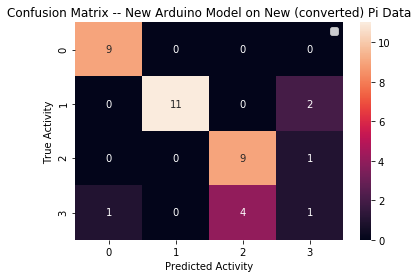

In [528]:
plot_cf(y_true, y_pred, ' -- New Arduino Model on New (converted) Pi Data')

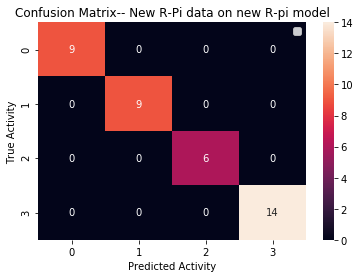

In [43]:
plot_cf(y_true, y_pred, '-- New R-Pi data on new R-pi model')

In [59]:
new_test_data = pd.read_csv('/home/ss26/Projects/Smart-Tools/data/test-raw-df-route-processed.csv').drop(columns='Unnamed: 0')

new_tf_dict = OrderedDict()
x_new = new_test_data.to_numpy().reshape([-1,11,10])
x_new_tf = tf.data.Dataset.from_tensor_slices(x_new)
new_tf_dict['test'] = x_new_tf
x_new_test = new_tf_dict['test']

In [63]:
x_new_tensors = [x for x in x_new_test]
y_true_new = np.array([3]*x_new.shape[0])

y_true_new

array([3, 3, 3, 3, 3, 3])

In [65]:
y_pred_new = np.argmax(model.predict(x_new), axis=1)
acc_newModel_newData = accuracy(y_true_new, y_pred_new)
# print(sum(acc_newModel_newData)/4)
# acc_newModel_newData

1/1 [==============================] - 0s 18ms/step
nan


array([nan, nan,  0.])

In [68]:
y_pred_new

array([2, 1, 1, 1, 1, 1])